In [25]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Tensorflow Stuff
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [26]:
with open('keVtoLightYield.pickle', 'rb') as handle:
    data = pickle.load(handle)

In [30]:
def loadRandomGaussianData(data, num):
    
    # Takes index from 
    indexToKey = [key for key in data.keys() if key not in "bins"]
    indexToKey.sort()
    indexToKey = np.array(indexToKey)
    
    # Gets the dimensions of the x and y data
    xDim = len(data[indexToKey[0]])
    yDim = len(indexToKey)
    
    # Normalizes the data
    def normalize(counts):
        bins = data["bins"]
        binWidth = bins[1] - bins[0]
        counts = counts / ( binWidth * sum(counts) )
        return counts

    # Randomly adds a gaussian peak to a 1D array
    def addGaussian(data, i):
        # Randomly picks the width and height of the gaussian
        # ~8 is placeholder for typical width of peak in the real-world data (depends on detector resolution)
        H = np.random.normal(loc = 20.0, scale = 10.0)
        W = int( np.abs(np.random.normal(loc = 30.0, scale = 15.0 / (np.abs(H) + 0.01) ))) + 1

        for k in range(-W, W + 1):
            if (i + k) >= len(data):
                break
            elif (i + k) < 0:
                continue
            else:
                data[i + k] += H * np.exp(- (2.5*k/W)**2)
                
    # Gets the detector response of a given neutron spectra
    def getX(yRow):
        xRow = np.zeros(xDim)
        for index in range(yDim):
            xRow += yRow[index] * data[indexToKey[index]]
            
        return normalize(xRow)
          
    x = np.zeros( (0, xDim) )
    y = np.zeros( (0, yDim) )
    #14045
    for _ in range(2000):
        yRow = np.zeros(len(indexToKey))

        i = np.random.randint(low = 0, high = yDim + 1)
        addGaussian(yRow, i)
        
        # Flip a coin and keep adding gaussian spikes
        p = np.random.random()
        while p > 0.2:
            i = np.random.randint(low = 0, high = yDim + 1)
            addGaussian(yRow, i)
            p = np.random.random()
                
        yRow = np.abs(yRow)
        yRow = yRow / sum(yRow)
        xRow = getX(yRow)

        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )    

    return x,y

In [31]:
def bootstrapModel(numNeurons2, alpha2):

    # Gets x and y dimension of the data 
    indexToKey = [key for key in data.keys() if key not in "bins"]
    indexToKey.sort()
    indexToKey = np.array(indexToKey)

    xDim = len(data[indexToKey[0]])
    yDim = len(indexToKey)
    
    error = []
    
    for _ in range(2):
        model = getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, alpha3, dropout)
        model.compile(loss = "categorical_crossentropy", optimizer = Adam() )

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, 
                                patience=1, verbose=0,
                                mode='min', restore_best_weights=True)

        x,y = loadRandomGaussianData(data, 500)
        
        model.fit(x, y, validation_split=0.1, batch_size = 60, callbacks=[monitor], verbose=0, epochs=10000)

        xtest, ytest = loadRandomGaussianData(data, 30)
        ypred = model( xtest )
        error.append( metrics.mean_squared_error(ytest, ypred) )
        
    print( "Error : " , np.mean(error), " ± ", np.std(error) )
    return - np.mean( error )

def getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout):
    
    numNeurons0 = int( numNeurons0 )
    numNeurons1 = int( numNeurons1 )
    numNeurons2 = int( numNeurons2 )
    
    model = keras.Sequential()
    model.add(keras.Input(xDim))
    if numNeurons0 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons0, activation=keras.layers.LeakyReLU(alpha=alpha0)))
    if numNeurons1 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons1, activation=keras.layers.LeakyReLU(alpha=alpha1)))
    if numNeurons2 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons2, activation=keras.layers.LeakyReLU(alpha=alpha2)))
    #model.add(Dense(yDim, activation=keras.layers.LeakyReLU(alpha=alpha3)))
    model.add(Dense(yDim, activation='softmax'))
    return model
    
    

In [32]:
pbounds = {#'numNeurons0' : (520,550),
           #'numNeurons1' : (320,350), 
           'numNeurons2' : (200,440), 
          #'alpha0' : (0.1, 0.2), 
          #'alpha1' : (0.2, 0.4), 
          'alpha2' : (0.2, 0.4), 
          #'dropout': (0, 0.8)
           }
optimizer = BayesianOptimization(
    f=bootstrapModel,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=4, n_iter=4)

print("Best Value : " , optimizer.max)
Best = optimizer.max

|   iter    |  target   |  alpha2   | numNeu... |
-------------------------------------------------


NameError: name 'alpha3' is not defined

In [33]:
Best = {'target': -0.0002807046020602577, 
        'params': {
            'numNeurons0': 532.5106601410772, 
            'numNeurons1': 341.60973480326476, 
            'numNeurons2': 439.0057187408672,
            'dropout'    : 0.01841923339536132,
            'alpha0': 0.13, 
            'alpha1': 0.23,
            'alpha2': 0.27
             }}

alpha0 = Best['params']['alpha0']
alpha1 = Best['params']['alpha1']
alpha2 = Best['params']['alpha2']
dropout = Best['params']['dropout']
numNeurons0 = Best['params']['numNeurons0']
numNeurons1 = Best['params']['numNeurons1']
numNeurons2 = Best['params']['numNeurons2']

indexToKey = [key for key in data.keys() if key not in "bins"]
indexToKey.sort()
indexToKey = np.array(indexToKey)

xDim = len(data[indexToKey[0]])
yDim = len(indexToKey)

model = getModel(xDim, yDim, numNeurons0, numNeurons1, numNeurons2, alpha0, alpha1, alpha2, dropout)

model.compile(loss = "categorical_crossentropy", optimizer = Adam() )

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-8, 
                        patience=10, verbose=0,
                        mode='min', restore_best_weights=True)

x,y = loadRandomGaussianData(data, 10000)
        
model.fit(x, y, validation_split=0.1, batch_size = 120, callbacks=[monitor], verbose=0, epochs=10000)

In [21]:
meanErr = []
for _ in range(20):
    xtest, ytest = loadRandomGaussianData(data, 300)
    error = metrics.mean_squared_error(ytest, model(xtest))
    meanErr.append(error)
    
print(np.mean(meanErr), " ± ", np.std(meanErr))

8.54613737279207e-05  ±  1.5596171019401064e-06


In [34]:
# (0, 4) and 100 Bins -> 0.000144 ± 1.57e-5
# (0, 4) and 50 Bins -> 0.000182 ± 1.5e-5
# (0, 1) and 100 Bins -> 0.000112 ± 2e-5
# (0, 0.5) and 100 Bins -> 0.000093 ± 3.6e-5
# (0, 0.5) and 50 Bins -> 0.000124 ± 2.8e-5
# (0, 0.5) and 200 Bins -> 5.433e-05 ± 9.5e-06

In [35]:
xtest, ytest = loadRandomGaussianData(data, 20)

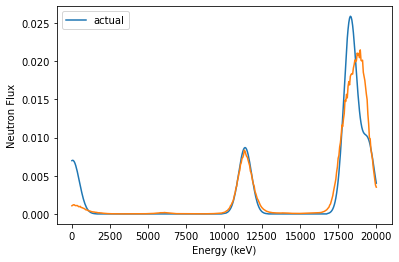

In [39]:
i = 15
plt.plot(np.linspace(1, 20000, 400), ytest[i], label = "actual")
plt.plot(np.linspace(1, 20000, 400), model(xtest)[i])
plt.xlabel("Energy (keV)")
plt.ylabel("Neutron Flux")
plt.legend()

array([2.00000000e+04, 1.97979899e+04, 1.95959798e+04, 1.93939697e+04,
       1.91919596e+04, 1.89899495e+04, 1.87879394e+04, 1.85859293e+04,
       1.83839192e+04, 1.81819091e+04, 1.79798990e+04, 1.77778889e+04,
       1.75758788e+04, 1.73738687e+04, 1.71718586e+04, 1.69698485e+04,
       1.67678384e+04, 1.65658283e+04, 1.63638182e+04, 1.61618081e+04,
       1.59597980e+04, 1.57577879e+04, 1.55557778e+04, 1.53537677e+04,
       1.51517576e+04, 1.49497475e+04, 1.47477374e+04, 1.45457273e+04,
       1.43437172e+04, 1.41417071e+04, 1.39396970e+04, 1.37376869e+04,
       1.35356768e+04, 1.33336667e+04, 1.31316566e+04, 1.29296465e+04,
       1.27276364e+04, 1.25256263e+04, 1.23236162e+04, 1.21216061e+04,
       1.19195960e+04, 1.17175859e+04, 1.15155758e+04, 1.13135657e+04,
       1.11115556e+04, 1.09095455e+04, 1.07075354e+04, 1.05055253e+04,
       1.03035152e+04, 1.01015051e+04, 9.89949495e+03, 9.69748485e+03,
       9.49547475e+03, 9.29346465e+03, 9.09145455e+03, 8.88944444e+03,
      

In [366]:
sum(model(xtest)[1])

<tf.Tensor: shape=(), dtype=float32, numpy=1.0000001>

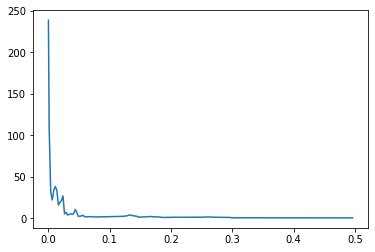

In [401]:
plt.plot(data["bins"], xtest[-10])


In [277]:
len(data["bins"])

200

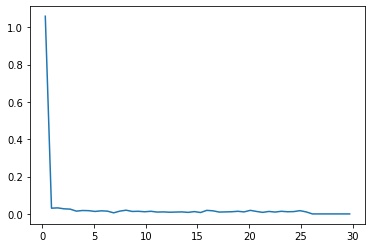

In [7]:
def normalize(counts):
    bins = data["bins"]
    binWidth = bins[1] - bins[0]
    counts = counts / ( binWidth * sum(counts) )
    return counts

for k in data:
    plt.plot(data["bins"], normalize(data[k]))